# Projeto ST - Nível Básico
## Abordagem 1: ARIMA, SARIMA, etc.
**Descrição**
Abordar os principios básicos de uma modelagem de série temporal utilizando os modelos autoregressimos ARIMA, SARIMA, etc.  


Neste caso, iremos utilizar o modelo SARIMA, pelas características apresentadas pela série temporal.  


Plus: Iremos considerar os parametros encontrados via análises e utilizando a biblioteca Autoarima.

In [ ]:
!pip install pmdarima

In [2]:
# Bibliotecas utilizadas

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 5
import seaborn as sns

from sklearn import metrics

from warnings import filterwarnings
filterwarnings('ignore')

from pmdarima import auto_arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

Vamos utilizar a famosa base "Air passengers", base de números de passageitos de avião com a granularidade mensal.

In [3]:
url = "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv"
df = pd.read_csv(url)
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**1° - Visualizando a série.**

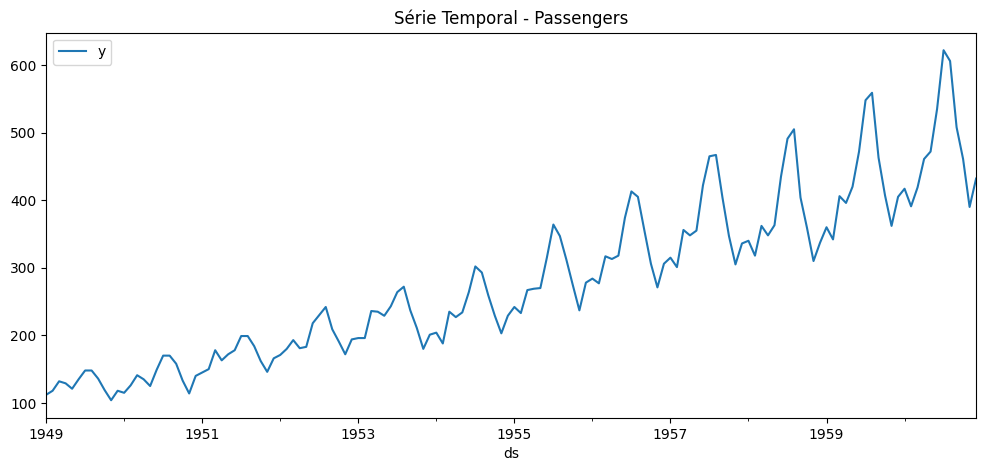

In [ ]:
df.plot()
plt.title('Série Temporal - Passengers')
plt.show()

**2° - Separando a base de treino e teste.**

(Em modelagens a base de teste deve ser utilizada apenas e somente apenas para a avaliação)

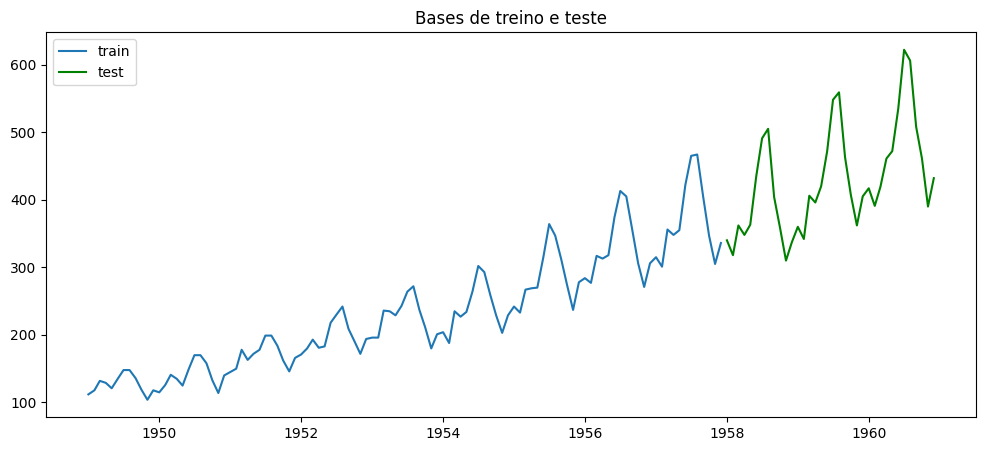

In [4]:
test_size = int(len(df) * 3/4)  ## 75% da base com foco no teste

train = df[:test_size]
test = df[test_size:]

plt.plot(train, label='train')
plt.plot(test, label='test', color='green')
plt.legend()
plt.title('Bases de treino e teste')
plt.show()

**3° - Verificar a série e seu histograma.**

O histograma pode nos indicar se estamos tratando de uma série com distribuição normal ou não, ponto importante para alguns tratamentos de nossos dados.

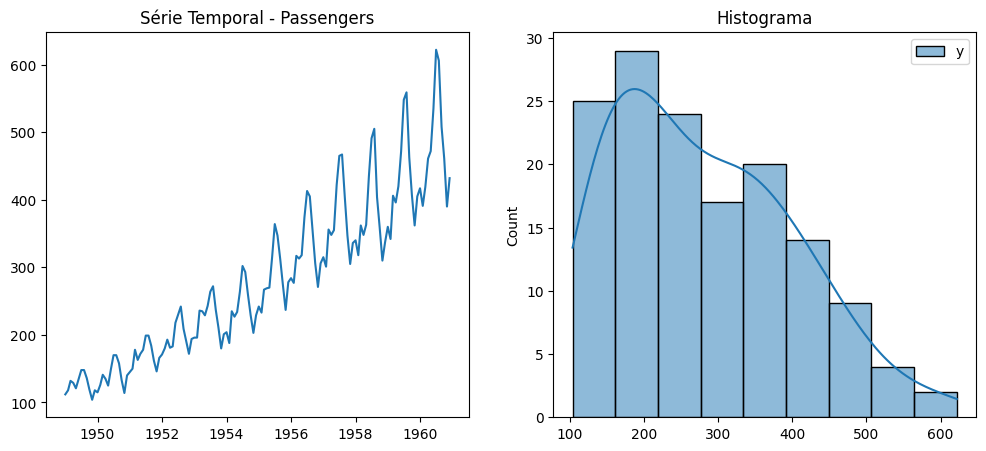

In [5]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(12,5))
ax.plot(df)
ax.set_title('Série Temporal - Passengers')

sns.histplot(df, ax=ax1, kde=True)
ax1.set_title('Histograma')

plt.show()

Podemos notar, que não encontramos uma distribuição normal.

**4° - Decompor nossa série.**  

1. Tendencia -> Aumento ou diminuição dos nossos valores;
2. Sazonalidade -> Padrões sazonais (de tempo em tempo) de aumento ou diminuição dos valores.
3. Residuos -> Pontos não explicador pela minha tendencia e sazonalidade. Importanta que esse gráfico não apresente tendencias ou sazonalidade, já que devem apresentam um ruído branco, ou seja, aleatoriedade em seus valores.  

Neste ponto, já inicia-se as análise para os nosso modelo SARIMA, já que a série pode apresentar Tendencia e Sazonalidade, afetando os nossos valores de order p,d,q e P,D,Q.

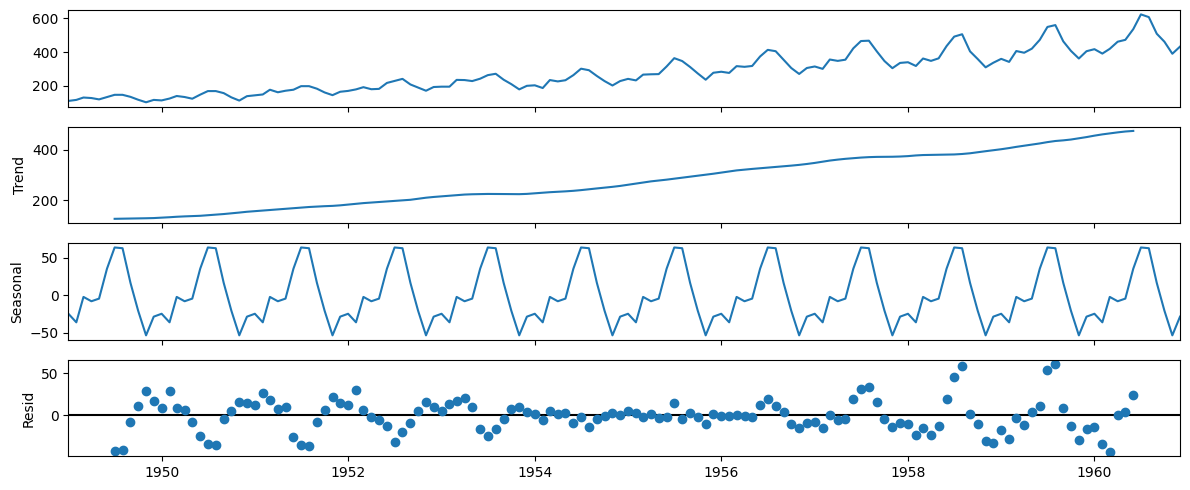

In [ ]:
result = seasonal_decompose(df, model='additive', period=12)
result.plot()
plt.show()

Notamos uma tendência e uma sazonalidade, além dos nossos ruídos apresentam uma flutuações aleatórias em sua grande maioria.  


Ponto importante é a detecção da sazonalidade, observada em nossa série.
Notamos que a mesma ocorre a cada 12 meses, portanto, iremos sempre considerar o s = 12.

**5° - Autocorrelação e Autocorreção Parcial.**

Ponto importante para entender as autocorrelações entre valores atuais e valores passados.

Está análise se torna essencial para as escolhas adequadas dos valores de order no SARIMA.

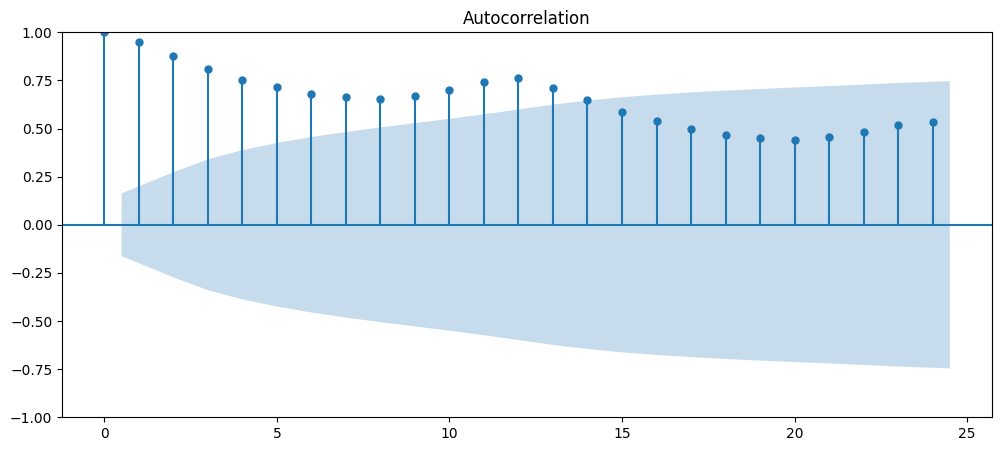

In [ ]:
plot_acf(df, lags=24, alpha=0.05)
plt.show()

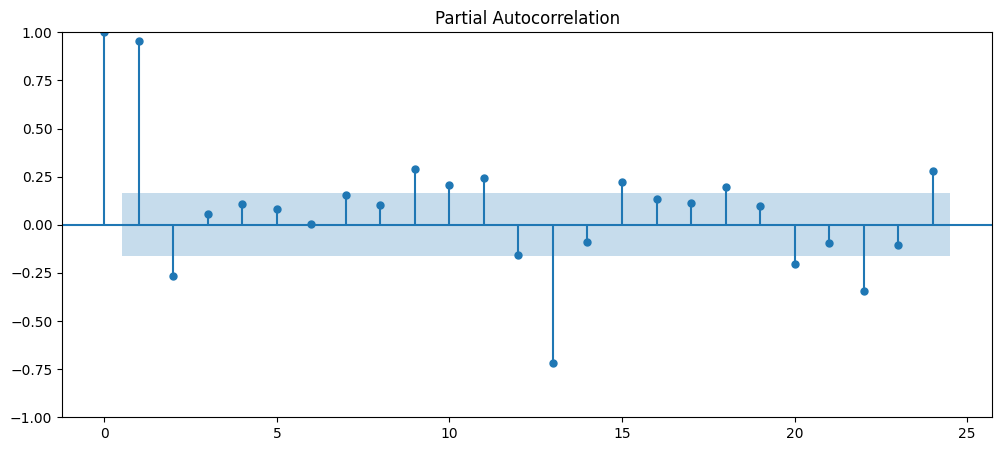

In [ ]:
plot_pacf(df, lags=24, alpha=0.05)
plt.show()

**6° - Teste de estacionariedade.**

Modelos baseados em autoregressivos, esperam uma série estacionária, ou seja, séries que apresentam média,variância e covariância constante ao longo do tempo.


Podemos aplicar o teste adfuller para verificar, lembrando:
Nosso valor de alpha = 0.05, ou seja, valores acima, não rejeitamos a hipótese que a série não é estacionária e valores abaixo, rejeitamos a hipótese e podemos supor que a nossa série é estacionária.*texto em itálico*

In [6]:
resultado_adf = adfuller(df['y'])
print(f"ADF Statistic: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


p-value > 0.05 -> Não sendo rejeitado a hipótese que a série não é estacionária.

**7° - Tornar a série estacionária.**

Os modelos ARIMA e SARIMA pressupoem estacionariedade (constância média, variância e autocovariância ao longo do tempo).

Vamos aplicar transformações e diferenciações para alcançar este requisito.

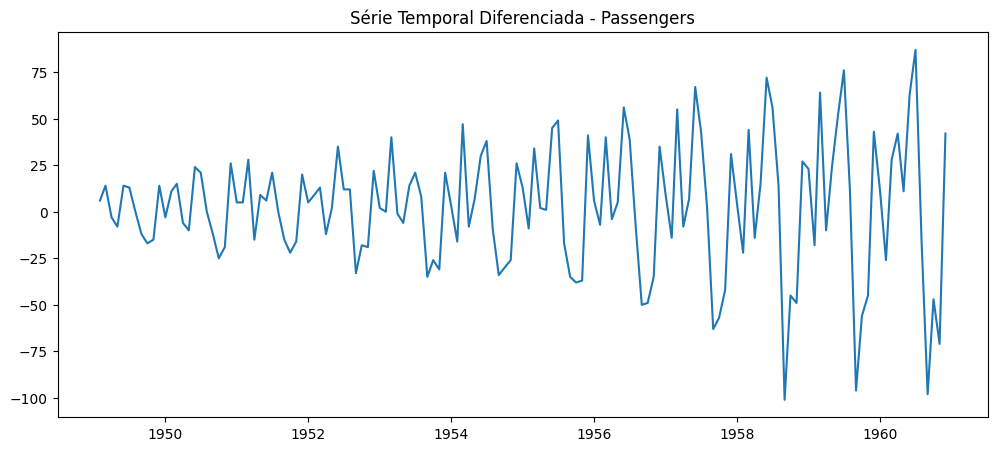

In [7]:
# Diferenciação ordem 1 para remoção da tendência.
df_diff = df.diff().dropna()

plt.plot(df_diff)
plt.title('Série Temporal Diferenciada - Passengers')
plt.show()

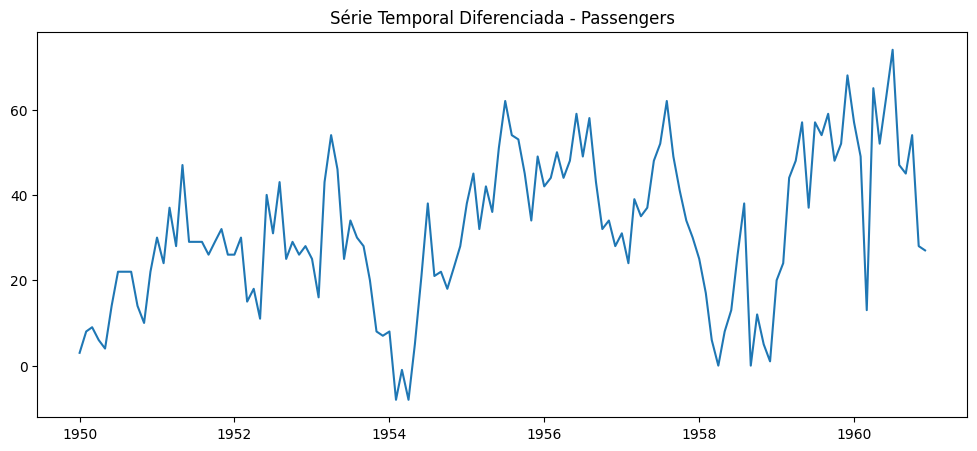

In [8]:
# Diferenciação sazonal, para remoção da sazonalidade anual (1 vez a cada ano)
sazonalidade=12
df_diff_sazonal = df.diff(periods=sazonalidade).dropna()

plt.plot(df_diff_sazonal)
plt.title('Série Temporal Diferenciada - Passengers')
plt.show()

**8° - Replicar Teste de estacionáriedade**

Vamos efetuar o teste Adf na série transformada

In [9]:
resultado_adf = adfuller(df_diff_sazonal['y'])
print(f"ADF Statistic: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")

ADF Statistic: -3.383020726492481
p-value: 0.011551493085514952


Temos p-value < 0.05 -> Rejeitando a hipótese que a série não é estacionária, indicando uma estacionariedade na série.

**9° - Indentificar os parametros p,d,q, P,D,Q para o modelo SARIMA**


p e q, pode-ser retirado dos gráficos de autocorrelação.

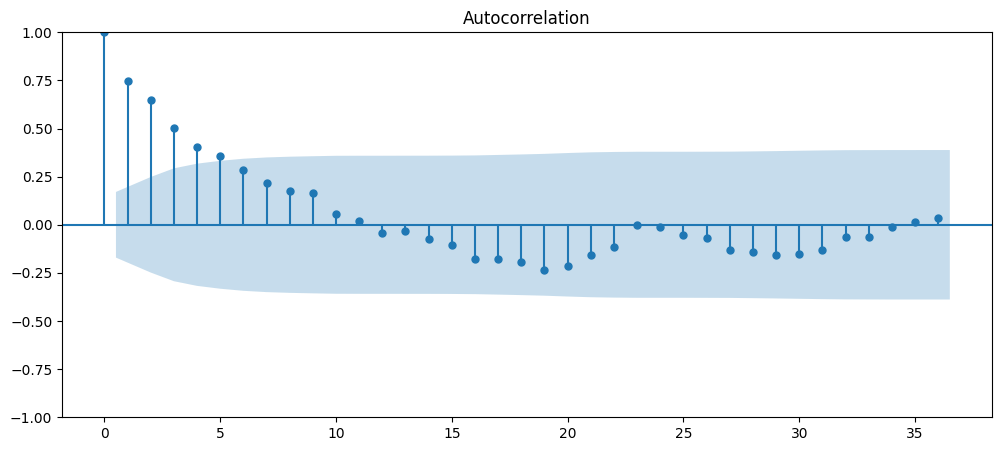

In [ ]:
plot_acf(df_diff_sazonal, lags=36, alpha=0.05)
plt.show()

Como fazer a identificação:  

No gráfico de autocorrelação iremos extrair os componente q e Q. Ou seja, iremos identificar o q quando algum lag apresentar uma boa autocorrelação fora do nosso intervalor alpha (área em azul), ou seja, podemos notar que até o lag 5 o pico está fora do intervalo.

O valor Q é da componente sazonal, ou seja, será que existe algum pico com boa autocorrelação fora do intervalo alpha, a cada 12 meses (que é a nossa sazonalidade). Neste caso, observamos o lag 12,24 e 36 e não notamos, portanto utilizamos Q = 0.  

q = 5 e Q = 0

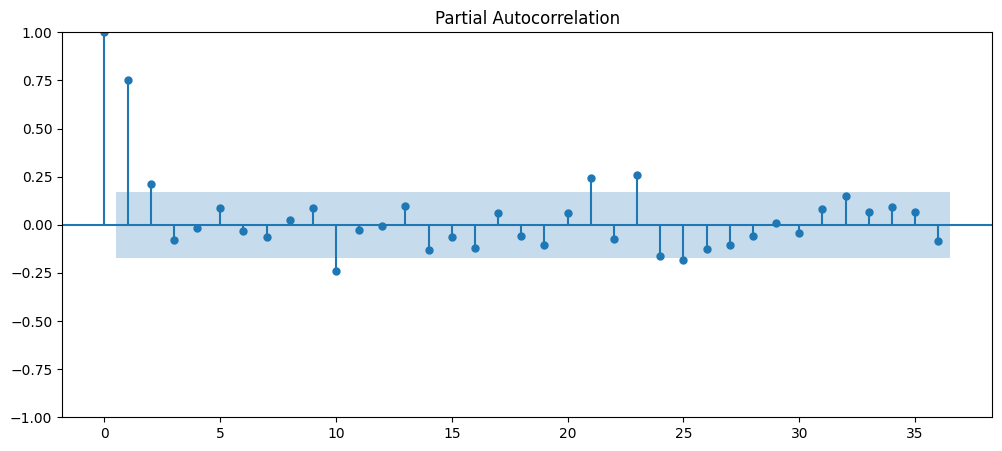

In [10]:
plot_pacf(df_diff_sazonal, lags=36, alpha=0.05)
plt.show()

Como fazer a identificação:  

Os componentes p e P no gráfico de autocorrelação parcial. Para identificar o p, devemos notar até que lag apresenta uma autorrelação significante com os valores passados, ou seja, neste caso, até o lag = 3.

Para o P da componente sazonal, devemos observar os lag 12,24 e 36, notamos que o lag 24 apresenta uma autocorrelação significante, então podemos utilizar 1 como o valor para o P.  

p = 3 e P = 1.  


Por final os valores de d e D. Lembramos que já efetuamos duas diferenciações, para remoção da tendência e sazonalidade, portanto precisamos levar essa característica para nosso modelo, ou seja, d = 1 e D = 1.

**9° - Criar o modelo SARIMA.**


Com todos os valores encontrados, vamos criar o modelo SARIMA;  
(p,d,q) = (3,1,5)  
(P,D,Q)[s] = (1,1,0)[12]

In [11]:
modelo = SARIMAX(
    train, order=(3,1,5),
    seasonal_order=(1,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit(disp=0)

print(modelo.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(3, 1, 5)x(1, 1, [], 12)   Log Likelihood                -291.340
Date:                             Thu, 14 Nov 2024   AIC                            602.680
Time:                                     12:25:39   BIC                            626.501
Sample:                                 01-01-1949   HQIC                           612.231
                                      - 12-01-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2246      0.876     -0.256      0.798      -1.942       1.493
ar.L2          0.5966      

**10° - Avaliar o modelo criado.**

Vamos efetuar o predict em nossa base de teste e plotar os resultados

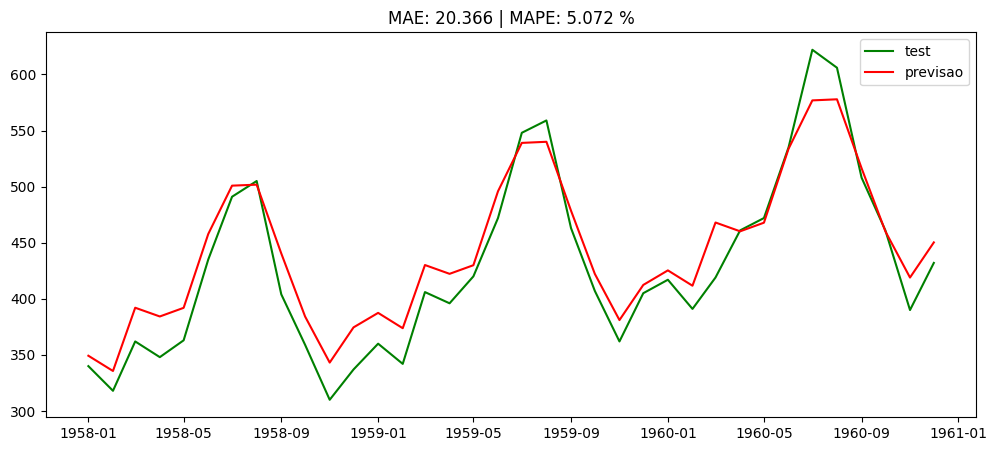

In [12]:
y_predict_sarima = modelo.predict(start=test.index[0], end=test.index[-1])
mae = metrics.mean_absolute_error(test['y'], y_predict_sarima)
mape = metrics.mean_absolute_percentage_error(test['y'], y_predict_sarima) * 100

# Plotando os resultados
plt.plot(test, label='test', color='green')
plt.plot(y_predict_sarima, label='previsao', color='red')
plt.title(f'MAE: {round(mae,3)} | MAPE: {round(mape,3)} %')
plt.legend()
plt.show()

**11° - Análise dos resultados**

1. Analisar as métricas de avaliação;
2. Analises os resíduos do modelo;  
    a. Neste caso o mesmo deve apresentar caracteristicas de um ruído branco;  
    b. Distribuição normal;  
    c. Variância Constante (Homoscedasticidade);  

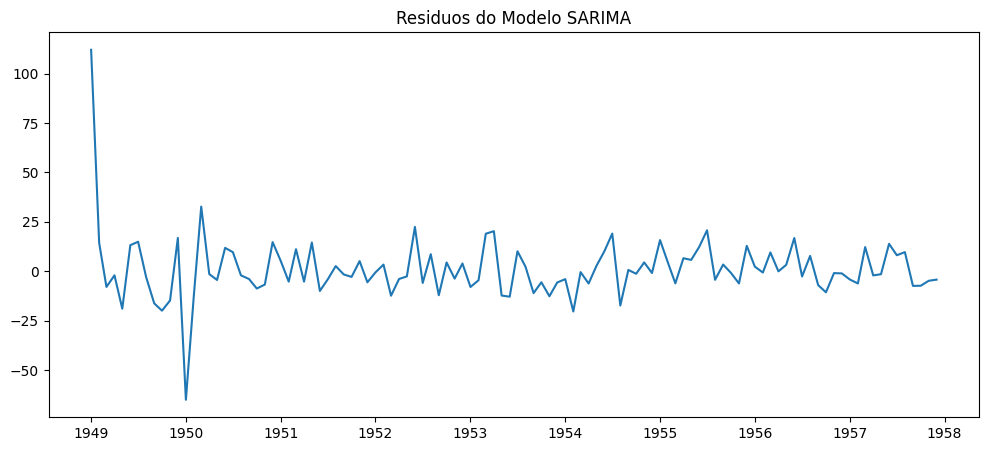

In [18]:
plt.plot(modelo.resid)
plt.title('Residuos do Modelo SARIMA')
plt.show()

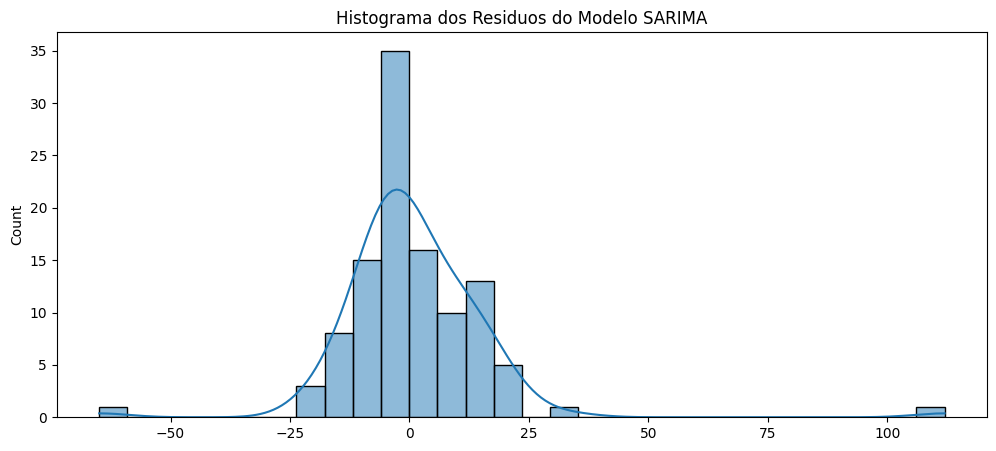

In [21]:
sns.histplot(modelo.resid, kde=True)
plt.title('Histograma dos Residuos do Modelo SARIMA')
plt.show()

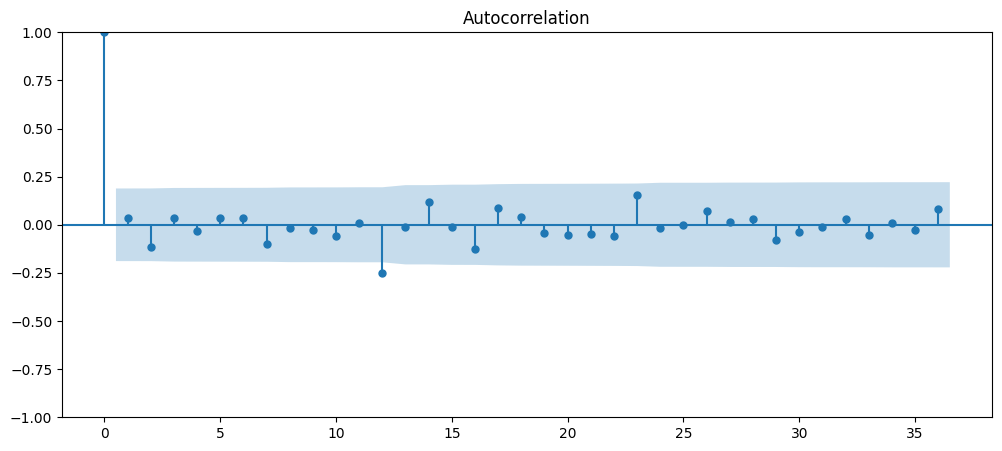

In [22]:
plot_acf(modelo.resid, lags=36, alpha=0.05)
plt.show()

**Métricas**
1. MAE de ~20 e MAPE de ~5%, indicando um ótimo resultado para nosso modelo.

**Resíduos**
1. Apresentou caracteristica de ruído branco;
2. Apresentou distribuição normal;
3. Não apresentou padrões temporais, significando que nosso modelo captou a estrutura dos dados.

**12° - Treinar o modelo com todos os dados**

Após validar a eficácia e métricas do nosso modelo, podemos finalizar o mesmo treinando com toda a nossa base.

In [24]:
modelo_final = SARIMAX(
    df, order=(3,1,5),
    seasonal_order=(1,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit(disp=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**13 ° - Efetuar uma previsão futura**

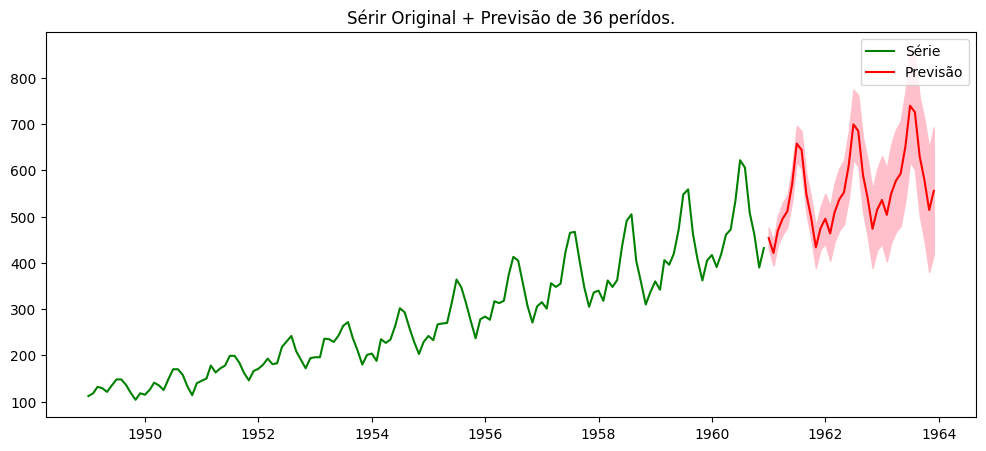

In [25]:
predict_36 = modelo_final.get_forecast(steps=36)
predict_36_df = predict_36.conf_int()
predict_36_df['mean'] = predict_36.predicted_mean

plt.plot(df, label='Série', color='green')
plt.plot(predict_36_df['mean'], label='Previsão', color='red')
plt.fill_between(predict_36_df.index, predict_36_df['lower y'], predict_36_df['upper y'], color='pink')
plt.title('Sérir Original + Previsão de 36 perídos.')
plt.legend()
plt.show()